# Quickstart

`AutoEmulate`'s goal is to make it easy to create an emulator for your simulation.

This tutorial's purpose is to walk you through the the basic functionality of the Python API using simple toy simulation as example.

We'll demonstrate following steps:
1. Getting input and output tensor data from our example simulation
2. Creating, comparing and evaluating Emulators with `AutoEmulate`
3. Using an `Emulator` model to predict outputs for new inputs
4. Saving `Emulator` models (and associated metadata) to disk

In [1]:
# General imports for the notebook
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Toy simulation

Before we build an emulator with AutoEmulate, we need to get a set of input/output pairs from our simulation to use as training data.

Below is a toy simulation for a projectile's motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). The simulation includes:
- Inputs: drag coefficient (log scale), velocity
- Outputs: distance the projectile travelled


In [2]:
from autoemulate.experimental.simulations.projectile import Projectile

projectile = Projectile()
n_samples = 500
x = projectile.sample_inputs(n_samples).float()
y = projectile.forward_batch(x).float()

x.shape, y.shape

Running simulations: 100%|██████████| 500/500 [00:00<00:00, 951sample/s]  


(torch.Size([500, 2]), torch.Size([500, 1]))

### Data

As you can see, our simulator inputs (`x`) and outputs (`y`) are PyTorch tensors.
PyTorch tensors are a common data structure used in machine learning, and `AutoEmulate` is built to work with them.

## Build and compare Emulators

With our simulator inputs and outputs, we can run a full machine learning pipeline, including data processing, model fitting, model selection and hyperparameter optimisation in just a few lines of code.

First, let's import `AutoEmulate` and check the names of the available Emulator models.


In [3]:
from autoemulate.experimental.compare import AutoEmulate

AutoEmulate.list_emulators()

,Emulator
0,GaussianProcessExact
1,GaussianProcessExactCorrelated
2,LightGBM
3,SupportVectorMachine
4,RadialBasisFunctions
5,RandomForest
6,MLP
7,EnsembleMLP
8,EnsembleMLPDropout


We're now ready run `AutoEmulate` to build and compare emulators.

This will fit (including hyperparameter tuning) emulator models to the simulation input and output to the data, evaluating performance on witheld test data.

In [4]:
# Run AutoEmulate with default settings
ae = AutoEmulate(x, y)

Comparing models: 100%|██████████| 9.00/9.00 [04:12<00:00, 28.1s/model]


For more information about the configuration options available, see the [AutoEmulate API docs](https://alan-turing-institute.github.io/autoemulate/reference/index.html).
Here's a brief overview of some important options:

<details>

<summary>Model selection</summary>

By default, `AutoEmulate` will use of all the listed emulator models, but you can also specify a subset to use if you already know which kinds of models are suitable for your data.

Specify models used by AutoEmulate with the `models` argument, for example:
```python
from autoemulate.experimental.emulators import GaussianProcessExact, RadialBasisFunctions
models = ["GaussianProcessExact", "RadialBasisFunctions"]
ae = AutoEmulate(x, y, models=models)
```

</details>

<details>

<summary>Logging</summary>

When running `AutoEmulate`, you may also wish to enable logging to track the progress and performance of the emulator comparison. You can do this by setting the `log_level` argument when creating the `AutoEmulate` instance:
```python
ae = AutoEmulate(x, y, models=models, log_level="info")
```

Try setting various log levels to see the difference. The options are "progress_bar", "debug", "info", "warning", "error", or "critical".

</details>

Now that we have run `AutoEmulate`, let's look at the summary for a comparison of emulator performance.

In [5]:
ae.summarise()

,model_name,x_transforms,y_transforms,config,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
1,GaussianProcessExactCorrelated,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function zero_mean at 0x31...,8.190084,0.999917,0.000040,0.999932,0.000012
4,RadialBasisFunctions,[StandardizeTransform()],[StandardizeTransform()],"{'kernel': 'cubic', 'degree': 1, 'smoothing': ...",12.429599,0.999622,0.000126,0.999467,0.000138
8,EnsembleMLPDropout,[StandardizeTransform()],[StandardizeTransform()],"{'n_emulators': 8, 'epochs': 200, 'layer_dims'...",33.334476,0.979776,0.008342,0.979086,0.003724
3,SupportVectorMachine,[StandardizeTransform()],[StandardizeTransform()],"{'kernel': 'poly', 'degree': 5, 'gamma': 'auto...",38.277473,0.960637,0.032892,0.961181,0.008780
5,RandomForest,[StandardizeTransform()],[StandardizeTransform()],"{'n_estimators': 173, 'min_samples_split': 15,...",41.207577,0.951190,0.018350,0.963808,0.009681
2,LightGBM,[StandardizeTransform()],[StandardizeTransform()],"{'num_leaves': 74, 'max_depth': 10, 'learning_...",47.018574,0.920745,0.032634,0.922911,0.013701
0,GaussianProcessExact,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function linear_mean at 0x...,51.077465,0.874375,0.036879,0.879480,0.018155
7,EnsembleMLP,[StandardizeTransform()],[StandardizeTransform()],"{'n_emulators': 6, 'epochs': 50, 'layer_dims':...",60.891102,0.788045,0.014807,0.792054,0.009980
6,MLP,[StandardizeTransform()],[StandardizeTransform()],"{'epochs': 100, 'layer_dims': [64, 32, 16], 'l...",100.126930,-0.720457,0.886906,0.244178,0.168395


# Choosing an Emulator

From this list, we can choose an emulator based on the index from the summary dataframe, or quickly get the best performing one using the `best_result` function, which picks based on the `r2_test` metric by default.

In [6]:
best = ae.best_result()
print("Model with id: ", best.id, " performed best: ", best.model_name)

Model with id:  1  performed best:  GaussianProcessExactCorrelated


Let's take a look at the configuration of the best model. These are the values of the model's hyperparameters.

In [7]:
best.config

{'mean_module_fn': <function autoemulate.experimental.emulators.gaussian_process.mean.zero_mean(n_features: int, n_outputs: torch.Size | None) -> gpytorch.means.zero_mean.ZeroMean>,
 'covar_module_fn': <function autoemulate.experimental.emulators.gaussian_process.kernel.rbf_plus_constant(n_features: int | None, n_outputs: torch.Size | None) -> gpytorch.kernels.kernel.Kernel>,
 'epochs': 200,
 'batch_size': 32,
 'activation': torch.nn.modules.activation.GELU,
 'lr': 0.03556480306223129,
 'likelihood_cls': gpytorch.likelihoods.multitask_gaussian_likelihood.MultitaskGaussianLikelihood}

We can quickly visualise the performance of this Emulator with a plot of its predictions against the simulator outputs.

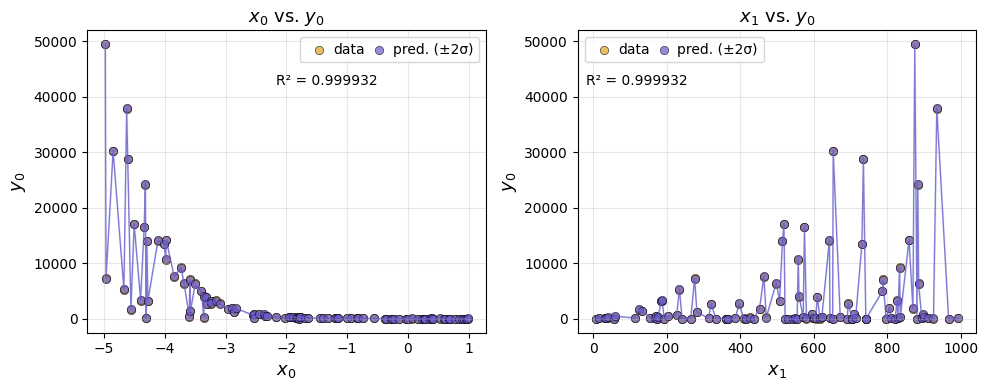

In [8]:
ae.plot(best)

## Predictions

We can use the model to make predictions for new inputs. Emulators in `AutoEmulate` can use the `predict` method to make predictions.


In [9]:
best.model.predict(x[:10])

MultitaskMultivariateNormal(mean shape: torch.Size([10, 1]))

# Saving and loading emulators

Emulators and their metadata (hyperparameter config and performance metrics) can be saved to disk and loaded again later.

In [10]:
# Make a directory to save Emulator models
import os
path = "my_emulators"
if not os.path.exists(path):
    os.makedirs(path)

Let's save the best result, the best performing emulator plus metadata, to disk.

In [11]:
# The use_timestamp paramater ensures a new result is saved each time the save method is called
best_result_filepath = ae.save(best, path, use_timestamp=True)
print("Model and metadata saved to: ", best_result_filepath)

Model and metadata saved to:  my_emulators/GaussianProcessExactCorrelated_1_20250717_144026


You should now have a two files saved to disk, one with the emulator model and one with the metadata that has the same name and a `.csv` extension.

You can later pass this filepath to the `load` method to use the model (and inspect its metadata) again.

In [12]:
loaded_result = ae.load(best_result_filepath)

In [13]:
print(loaded_result.model_name)
print(loaded_result.config)

GaussianProcessExactCorrelated
{'mean_module_fn': 'zero_mean', 'covar_module_fn': 'rbf_plus_constant', 'epochs': 200, 'batch_size': 32, 'activation': 'GELU', 'lr': 0.03556480306223129, 'likelihood_cls': 'MultitaskGaussianLikelihood'}


In [14]:
loaded_result.model.predict(x[:10])

MultitaskMultivariateNormal(mean shape: torch.Size([10, 1]))